In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp39-cp39-linux_x86_64.whl size=661963 sha256=06c8f110fdbab707c92d2f4f7a710bc3a869af05ec5f8203b8c6710ccf39374a
  Stored in directory: /root/.cache/pip/wheels/82/09/27/74d8e31ed19c530166e0d263aabe1ea57465e255615bda8fc0
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69866 sha256=742a1e34809313eb14a2c1e17544deff07320781bd83e13425debba99debe95f
  Stored in directory: /root/.cache/pip/wheels/76/ee/8c

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from time import time


In [3]:
%%writefile mandelbrot.cu

#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>


extern "C" __global__ void mandelbrot_ker(float * lattice, float * mandelbrot_graph, int max_iters, float upper_bound_squared, int lattice_size)
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    
    if ( tid < lattice_size*lattice_size )
    {
        int i = tid % lattice_size;
        int j = lattice_size - 1 - (tid / lattice_size);
        
        float c_re = lattice[i];
        float c_im = lattice[j];
        
        float z_re = 0.0f;
        float z_im = 0.0f;
        
        
        
        mandelbrot_graph[tid] = 1;
        
        for (int k = 0; k < max_iters; k++)
        {
            float temp;
            
            temp = z_re*z_re - z_im*z_im + c_re;
            z_im = 2*z_re*z_im + c_im;
            z_re = temp;
            
            if ( (z_re*z_re + z_im*z_im) > upper_bound_squared )
            {
                mandelbrot_graph[tid] = 0;
                break;
            }
        
        }
        
    }
    
    return;
}



Writing mandelbrot.cu


In [5]:
#compile the mandelbrot.cu file into mandelbrot.ptx
!nvcc -ptx -o mandelbrot.ptx mandelbrot.cu

In [6]:
mandel_mod = pycuda.driver.module_from_file('./mandelbrot.ptx')
mandel_ker = mandel_mod.get_function('mandelbrot_ker')

def mandelbrot(breadth, low, high, max_iters, upper_bound):

    lattice = gpuarray.to_gpu(np.linspace(low, high, breadth, dtype=np.float32))
    out_gpu = gpuarray.empty(shape=(lattice.size,lattice.size), dtype=np.float32)
    
    gridsize = int(np.ceil(lattice.size**2 / 32))
    
    
    mandel_ker(lattice, out_gpu, np.int32(256), np.float32(upper_bound**2), np.int32(lattice.size), grid=(gridsize, 1, 1), block=(32,1,1))
    
    out = out_gpu.get()
    
    return out


It took 0.006700277328491211 seconds to calculate the Mandelbrot graph.


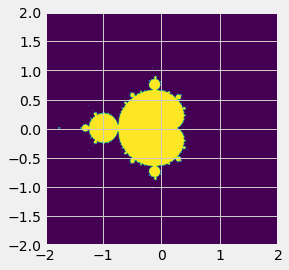

In [7]:
t1 = time()
mandel = mandelbrot(512,-2,2,256, 2)
t2 = time()

mandel_time = t2 - t1

print(f'It took {mandel_time} seconds to calculate the Mandelbrot graph.') 

plt.figure(1)
plt.imshow(mandel, extent=(-2, 2, -2, 2))
plt.show()
